In [1]:
!pip install -U fiona shapely pyproj rtree

!pip install -U geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.2 MB/s eta 0:00:00
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.13.2
    Uninstalling geopandas-0.13.2:
      Successfully uninstalled geopandas-0.13.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt

from os import mkdir

from tqdm import tqdm

plt.rcParams['font.family'] = 'serif'

In [4]:

def crear_carpeta(ruta):
    try:
        mkdir(ruta)
        print(f"Carpeta '{ruta}' creada exitosamente.")
    except FileExistsError:
        print(f"La carpeta '{ruta}' ya existe.")
    except Exception as e:
        print(f"Error al crear la carpeta '{ruta}': {e}")

In [5]:
colonias = gpd.read_file('zip:///content/drive/MyDrive/Colonias CDMX/data/espacial/colonias_seduvi.zip').drop(columns=['pob_2010','area','perimetro','cve_ent'])

In [6]:
pgj_full = pd.read_csv('/content/drive/MyDrive/Colonias CDMX/data/variables/da_carpetas_completa_abril_2023.csv',
                  usecols=['ao_hechos','longitud','latitud','categoria_delito']
                  ).query('latitud>0 & ao_hechos>2010')
pgj_full['cnt'] = 1

In [14]:
new_columns = {
    'DELITO DE BAJO IMPACTO': 'DelBajo',
    'HECHO NO DELICTIVO': 'NoDel',
    'HOMICIDIO DOLOSO': 'HomDol',
    'LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO': 'LesArma',
    'ROBO A CASA HABITACIÓN CON VIOLENCIA': 'RobCasa',
    'ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA': 'RobCajero',
    'ROBO A NEGOCIO CON VIOLENCIA': 'RobNeg',
    'ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA': 'RobMicro',
    'ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA': 'RobTaxi',
    'ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA': 'RobMetro',
    'ROBO A REPARTIDOR CON Y SIN VIOLENCIA': 'RobRepart',
    'ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA': 'RobTranse',
    'ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA': 'RobTrans',
    'ROBO DE VEHÍCULO CON Y SIN VIOLENCIA': 'RobVehi',
    'SECUESTRO': 'Secuestro',
    'VIOLACIÓN': 'Violacion',
    'FEMINICIDIO': 'Feminic',
    'PLAGIO O SECUESTRO':'PlagSec'

}

In [18]:
def process_pgj_data(pgj_full, colonias, year):
    pgj = pgj_full.query(f'ao_hechos=={year}').copy()
    geo_pgj = gpd.GeoDataFrame(pgj,
                            geometry=gpd.points_from_xy(pgj.longitud, pgj.latitud),
                            crs='epsg:4326').to_crs(colonias.crs)

    colonias_pgj = gpd.sjoin_nearest(colonias, geo_pgj,
                                    distance_col='dist', how="right")

    colonias_join = colonias_pgj[~colonias_pgj.dist.isna()].query('dist<1000').sort_values('dist')
    colonias_join = colonias_join.groupby(['cve_col','colonia','categoria_delito']).cnt.sum().unstack().reset_index().fillna(0)

    colonias_final = pd.merge(colonias, colonias_join, on=['cve_col','colonia'])

    colonias_final['Total'] = colonias_final.iloc[:,4:].sum(axis=1)
    colonias_final['area'] = colonias_final.area
    colonias_final['total_ix'] = 100*(colonias_final['Total']/colonias_final.area)

    colonias_final.rename(columns=new_columns, inplace=True)

    colonias_final = pd.concat([colonias_final,
                                colonias[~(colonias.cve_col.isin(colonias_final.cve_col))]],
                                ignore_index=True
                                ).fillna(0)

    return colonias_final

In [19]:
for year in tqdm(pgj_full.ao_hechos.unique()):
    year = int(year)
    colonias_final = process_pgj_data(pgj_full, colonias, year)

    crear_carpeta(f'/content/drive/MyDrive/Colonias CDMX/colonias_fgj/{year}')

    colonias_final.to_file(f'/content/drive/MyDrive/Colonias CDMX/colonias_fgj/{year}/{year}.shp',
                           index=False)


  0%|          | 0/13 [00:00<?, ?it/s]

La carpeta '/content/drive/MyDrive/Colonias CDMX/colonias_fgj/2016' ya existe.


  8%|▊         | 1/13 [00:17<03:25, 17.11s/it]

La carpeta '/content/drive/MyDrive/Colonias CDMX/colonias_fgj/2015' ya existe.


 15%|█▌        | 2/13 [00:20<01:38,  8.94s/it]

La carpeta '/content/drive/MyDrive/Colonias CDMX/colonias_fgj/2012' ya existe.


 23%|██▎       | 3/13 [00:22<00:58,  5.80s/it]

La carpeta '/content/drive/MyDrive/Colonias CDMX/colonias_fgj/2014' ya existe.


 31%|███       | 4/13 [00:24<00:40,  4.53s/it]

La carpeta '/content/drive/MyDrive/Colonias CDMX/colonias_fgj/2011' ya existe.


 38%|███▊      | 5/13 [00:26<00:28,  3.61s/it]

La carpeta '/content/drive/MyDrive/Colonias CDMX/colonias_fgj/2013' ya existe.


 46%|████▌     | 6/13 [00:29<00:21,  3.10s/it]

La carpeta '/content/drive/MyDrive/Colonias CDMX/colonias_fgj/2017' ya existe.


 54%|█████▍    | 7/13 [00:48<00:49,  8.30s/it]

La carpeta '/content/drive/MyDrive/Colonias CDMX/colonias_fgj/2018' ya existe.


 62%|██████▏   | 8/13 [01:10<01:03, 12.79s/it]

La carpeta '/content/drive/MyDrive/Colonias CDMX/colonias_fgj/2019' ya existe.


 69%|██████▉   | 9/13 [01:30<01:00, 15.10s/it]

La carpeta '/content/drive/MyDrive/Colonias CDMX/colonias_fgj/2020' ya existe.


 77%|███████▋  | 10/13 [01:51<00:50, 16.77s/it]

La carpeta '/content/drive/MyDrive/Colonias CDMX/colonias_fgj/2021' ya existe.


 85%|████████▍ | 11/13 [02:11<00:35, 17.80s/it]

La carpeta '/content/drive/MyDrive/Colonias CDMX/colonias_fgj/2022' ya existe.


 92%|█████████▏| 12/13 [02:29<00:18, 18.07s/it]

La carpeta '/content/drive/MyDrive/Colonias CDMX/colonias_fgj/2023' ya existe.


100%|██████████| 13/13 [02:36<00:00, 12.07s/it]


In [8]:
colonias_final = process_pgj_data(pgj_full, colonias, 2023)

In [17]:
colonias_final.crs

<Projected CRS: EPSG:32614>
Name: WGS 84 / UTM zone 14N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 102°W and 96°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Manitoba; Nunavut; Saskatchewan. Mexico. United States (USA).
- bounds: (-102.0, 0.0, -96.0, 84.0)
Coordinate Operation:
- name: UTM zone 14N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
colonias_final.columns

Index(['alcaldia', 'cve_col', 'colonia', 'geometry', 'DELITO DE BAJO IMPACTO',
       'HECHO NO DELICTIVO', 'HOMICIDIO DOLOSO',
       'LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO',
       'ROBO A CASA HABITACIÓN CON VIOLENCIA',
       'ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA',
       'ROBO A NEGOCIO CON VIOLENCIA',
       'ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA',
       'ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA',
       'ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA',
       'ROBO A REPARTIDOR CON Y SIN VIOLENCIA',
       'ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA',
       'ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA',
       'ROBO DE VEHÍCULO CON Y SIN VIOLENCIA', 'SECUESTRO', 'VIOLACIÓN',
       'Total', 'area'],
      dtype='object')

In [ ]:
colonias_final['total_ix'] = 100*(colonias_final['Total']/colonias_final.area)

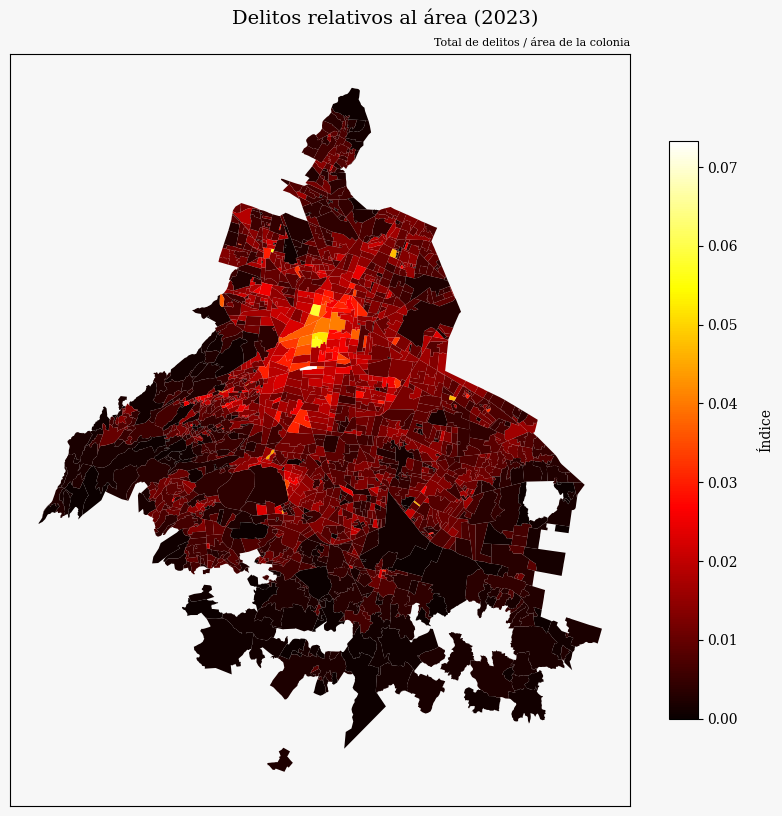

In [20]:
fig = plt.figure(figsize=(10, 15))

ax = colonias_final.plot(column="total_ix", ax=plt.gca(),
                             cmap='hot', legend=True,
                             legend_kwds={"shrink": 0.5},# vmax=20000
                         )


#metro.plot(ax=ax, color='azure', markersize=15, ec='maroon')


color_fondo = '#f7f7f7'
ax.set_facecolor(color_fondo)
fig.patch.set_facecolor(color_fondo)


ax.set_xticks([])
ax.set_yticks([])

plt.suptitle("Delitos relativos al área (2023)", y=0.775, fontsize=14)
plt.title('Total de delitos / área de la colonia', loc='right', fontsize=8)

cax = ax.get_figure().get_axes()[1]
cax.set_ylabel('Índice', rotation=90, labelpad=15)

# Guardar el gráfico como una imagen (esta línea está comentada)
plt.savefig('/content/drive/MyDrive/Colonias CDMX/colonias_fgj/mapa_delitos_rel_2023.png', dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()